In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import os
pd.options.mode.chained_assignment = None
from typing import List, Tuple

In [10]:
class WellCorrelationDataset:
    
    def __init__(self, 
                 root : str = '../data/',
                 train_preload : bool = True,
                 test_preload : bool = False,
                 fill_na_method : str = None):
        self.root : str = root
        self.train_path : str = os.path.join(self.root, 'train.csv')
        self.test_path : str = os.path.join(self.root, 'test.csv')
        self.train_preload : bool = train_preload
        self.test_preload : bool = test_preload
        self.fill_na_method : str = fill_na_method
        self.train_data : pd.DataFrame = None
        self.test_data : pd.DataFrame = None
        self.wells_list = None
        self.target_groups = None
        self.group_num_map = {}
        self.used_cols = ['WELL', 'Z_LOC', 'GR', 'DTC', 'GROUP']

        self.__preload__()
        
    def __preload__(self):
        if self.train_preload:
            self.train_data = pd.read_csv(self.train_path, delimiter=';')
            self.train_data.loc[:, 'Z_LOC'] *= -1
            self.train_data.sort_values(by = ['WELL', 'Z_LOC'])
            self.wells_list = self.train_data.WELL.unique()
            self.target_groups = self.train_data.GROUP.unique()
            for i, label in enumerate(self.target_groups):
                self.group_num_map.update({label : i})
            self.train_data.loc[:, 'GROUP_NUM'] = self.train_data.GROUP.map(self.group_num_map)
            self.used_cols += ['GROUP_NUM']
        
        if self.test_preload:
            self.test_preload = pd.read_csv(self.test_path, delimiter=';')
    
    def get_well(self, idx : str, process_na:bool = True):
        assert(idx in self.wells_list)
        well_df = self.train_data.loc[self.train_data.WELL == idx, self.used_cols]
        if process_na:
            if self.fill_na_method is None:
                well_df.fillna(-100, inplace = True)
            else:
                assert(self.fill_na_method in ['ffill', 'bfill', 'pad'])
                well_df.fillna(method = self.fill_na_method, inplace = True)

#             well_df.dropna(inplace = True)
        return well_df
    
    def get_matching_wells_id(self, tmpt : str = ""):
        m_wells = []
        for w in self.wells_list:
            m_wells += [w] if tmpt in w else []
        return m_wells
    
    def show_wells_info(self, idx : str = ""):
        df = self.get_well(idx)
        

In [11]:
dataset = WellCorrelationDataset(fill_na_method=None)

In [12]:
matching_wells = dataset.get_matching_wells_id("31")
print(f'matching wells ids : {matching_wells}')

matching wells ids : ['31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9', '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5', '31/5-4 S', '31/6-5', '31/6-8']


/home/shivam/.venv/clort/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


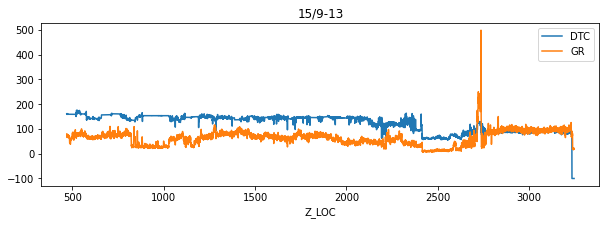

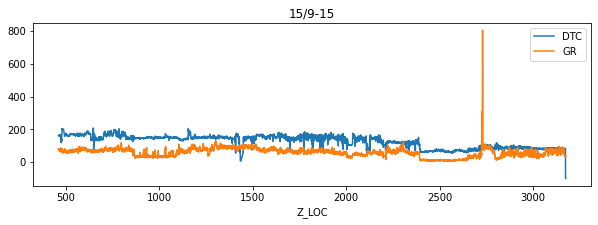

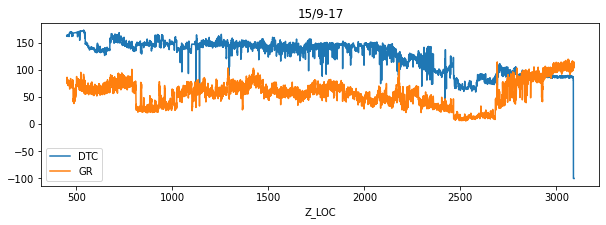

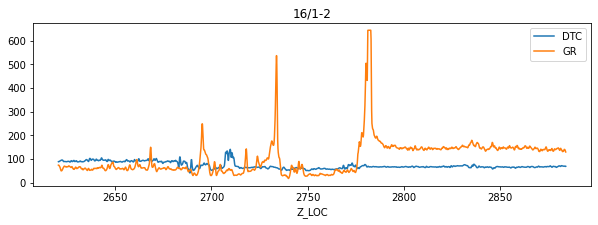

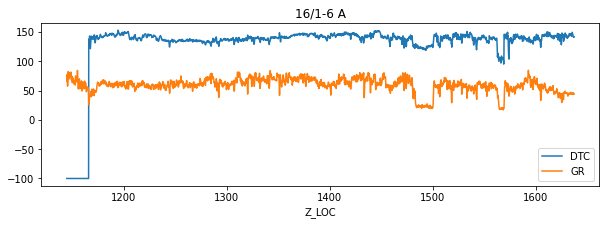

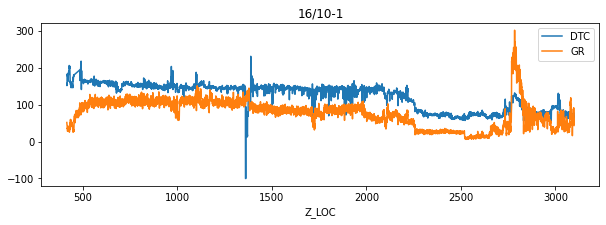

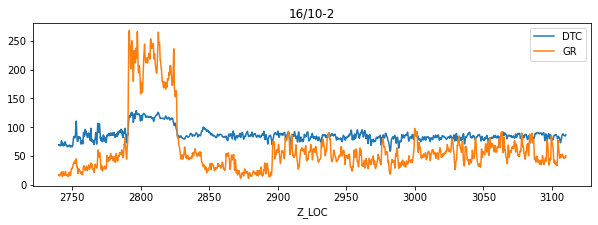

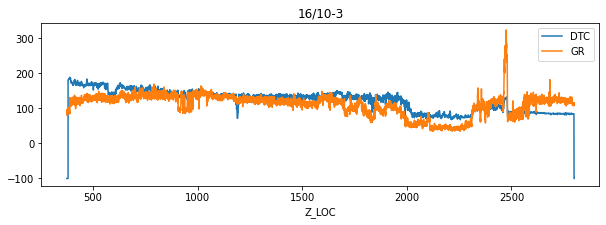

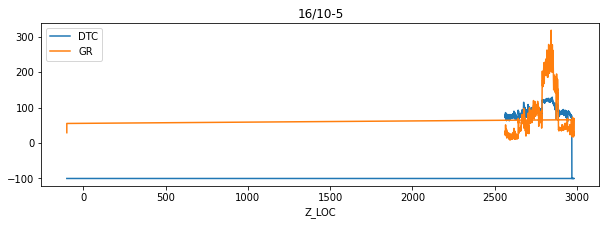

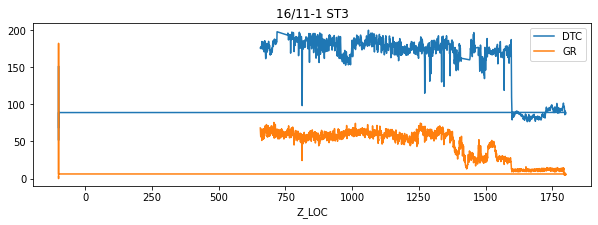

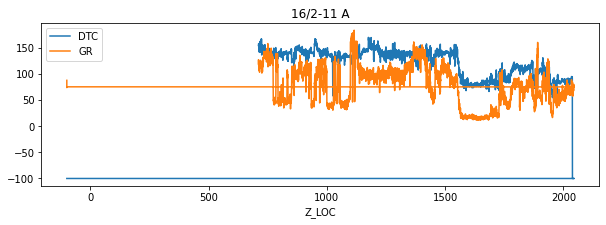

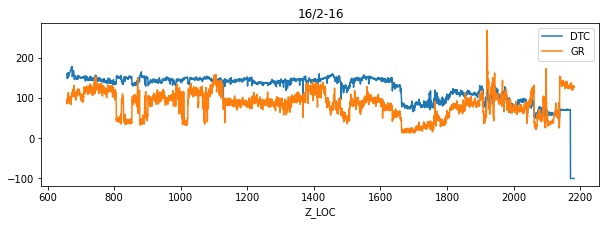

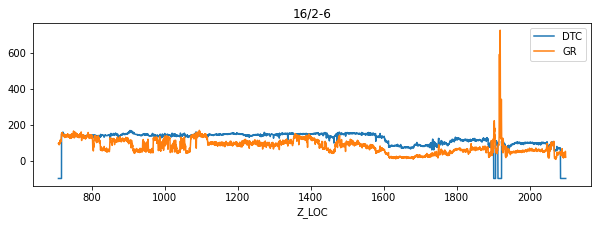

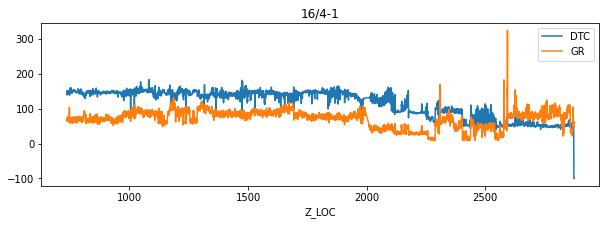

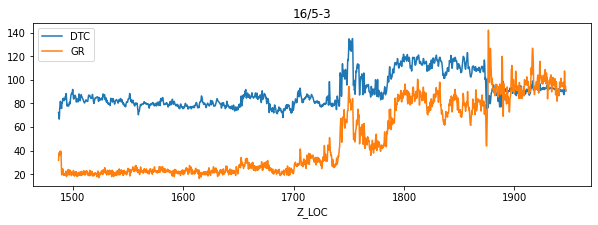

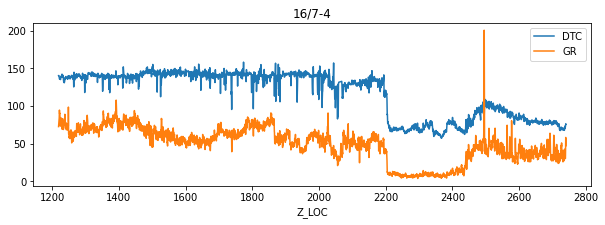

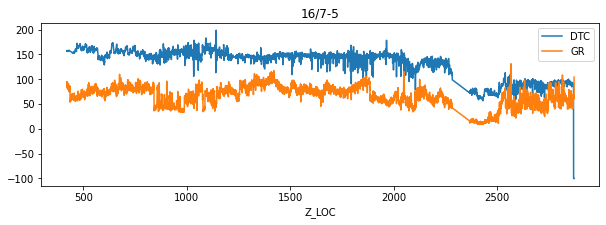

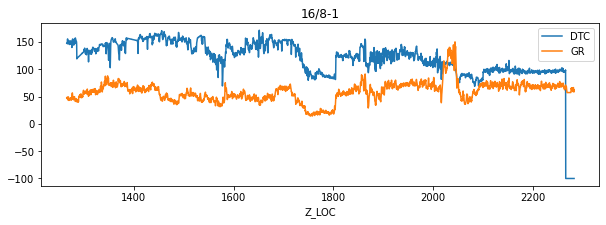

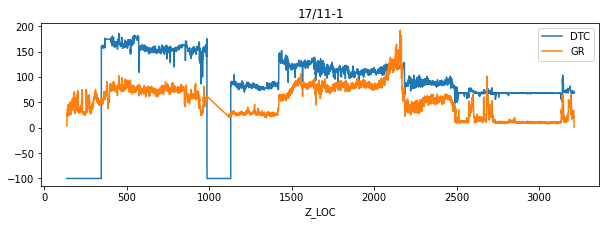

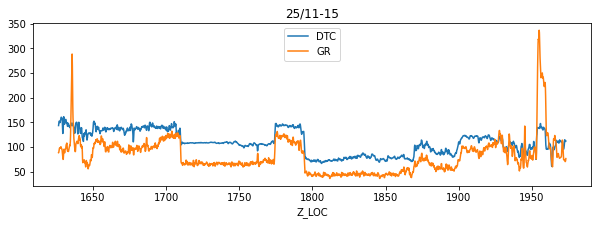

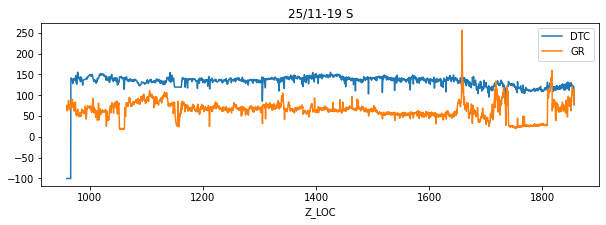

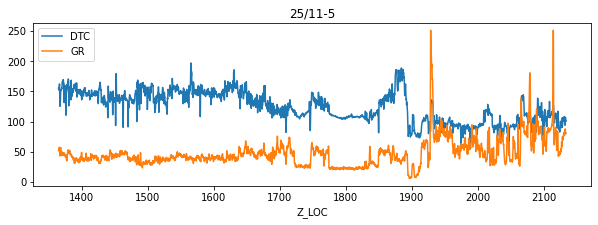

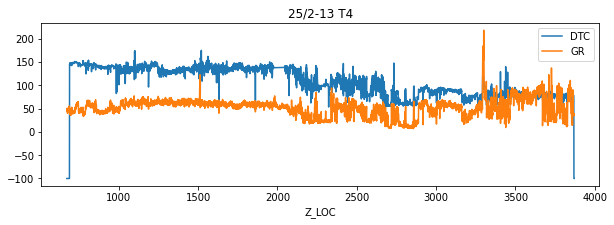

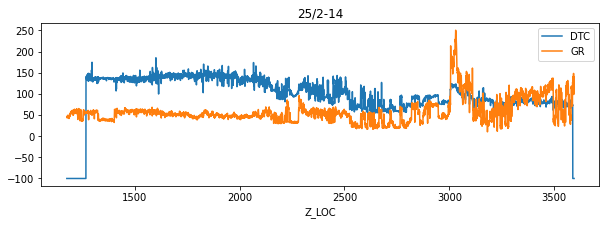

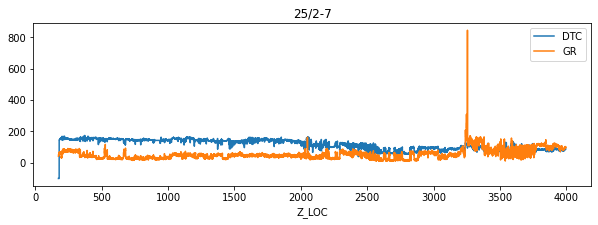

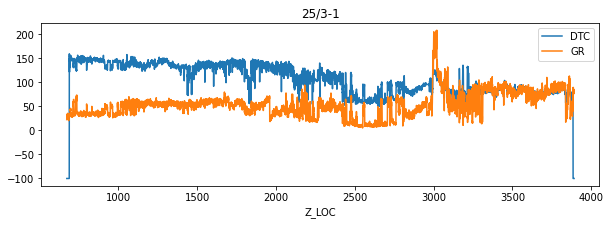

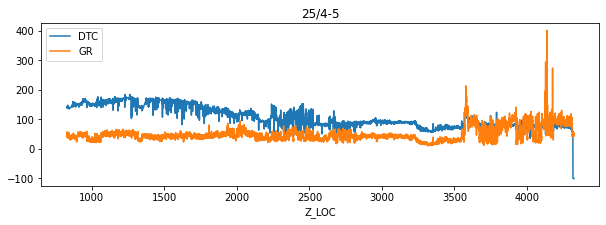

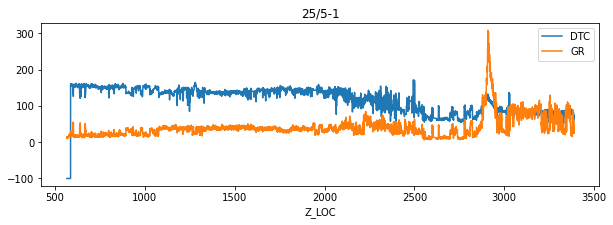

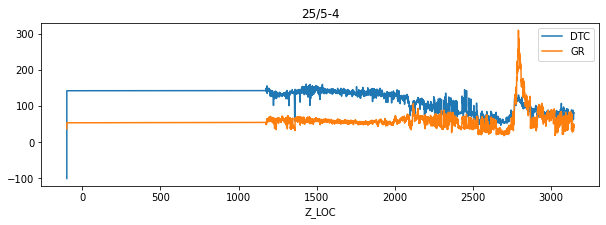

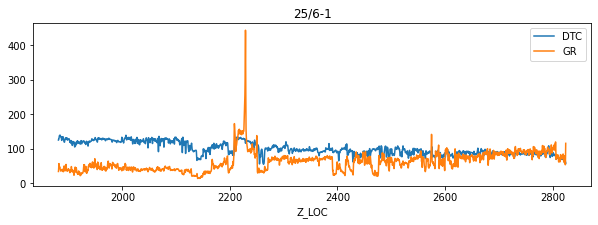

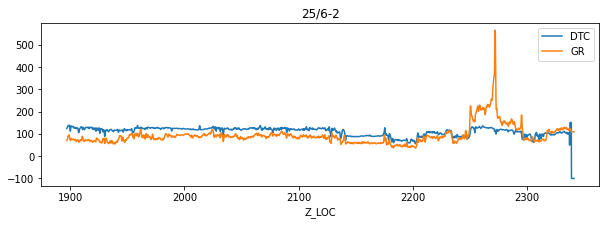

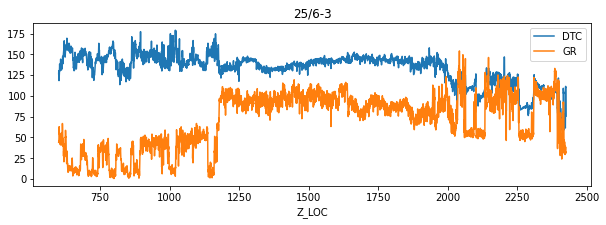

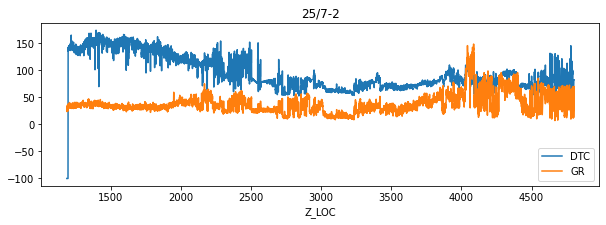

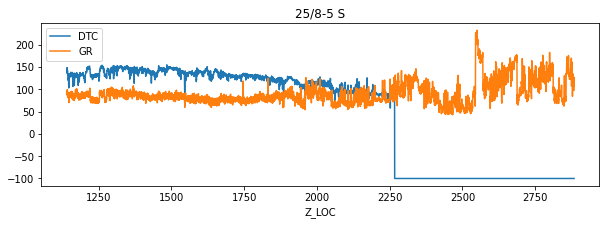

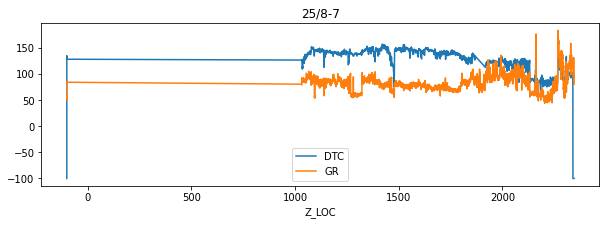

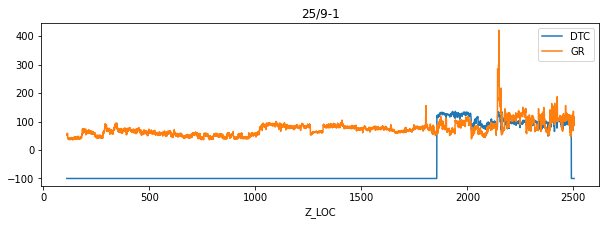

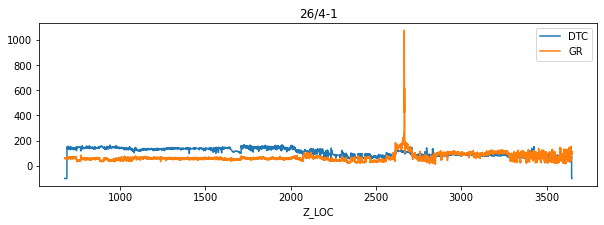

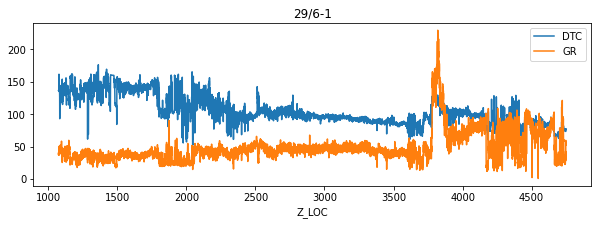

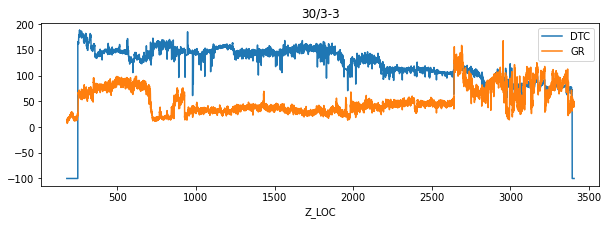

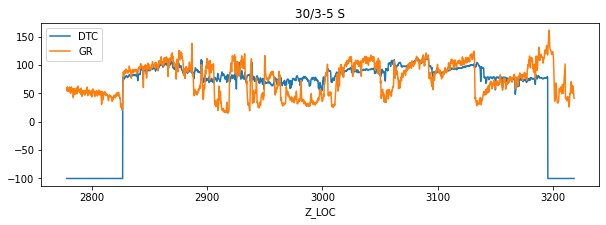

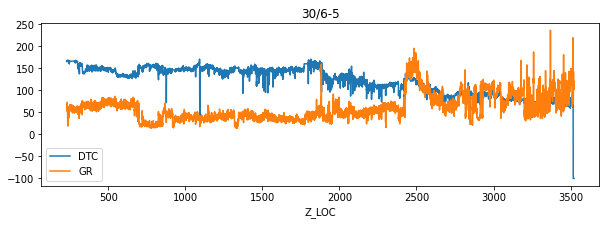

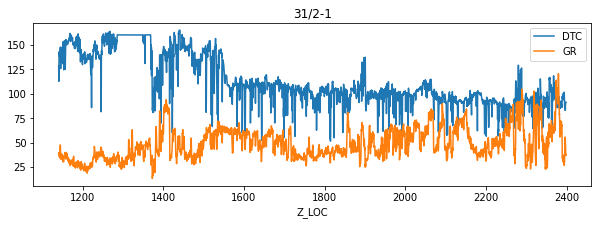

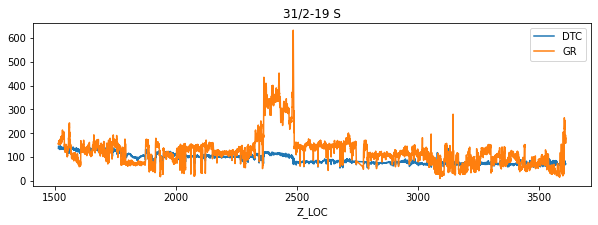

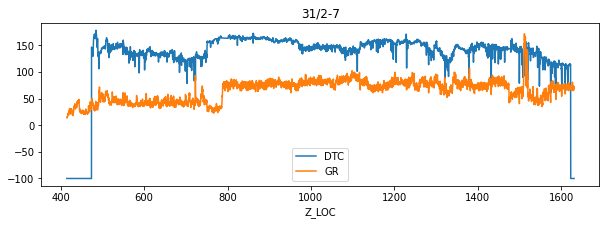

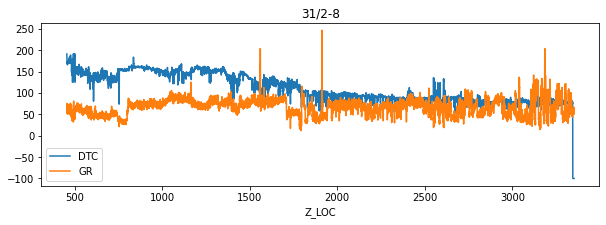

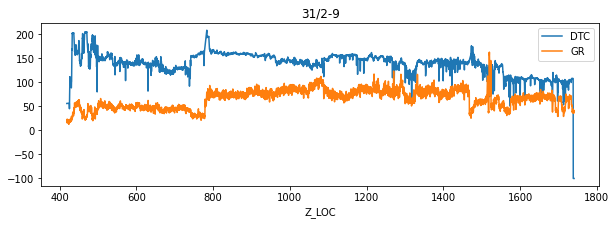

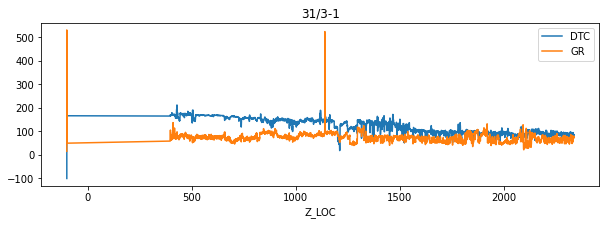

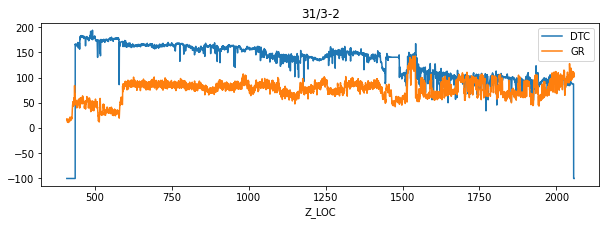

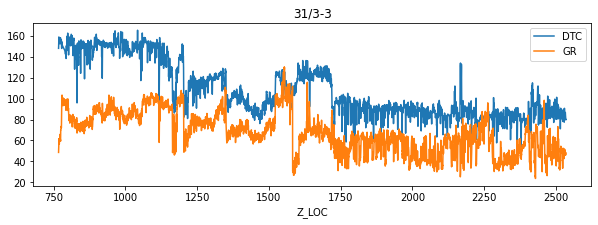

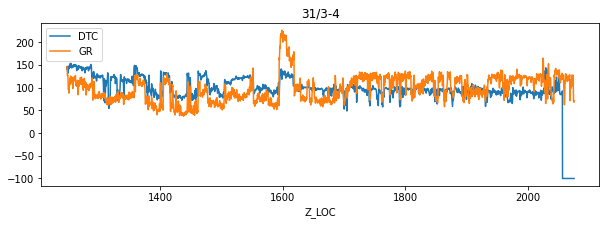

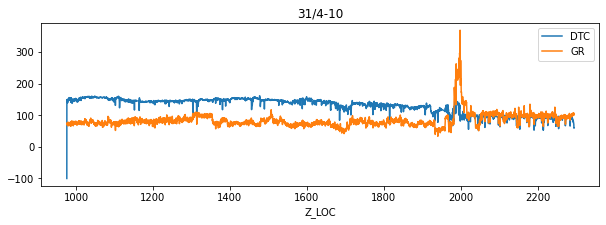

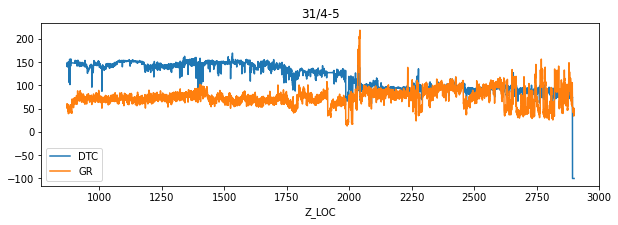

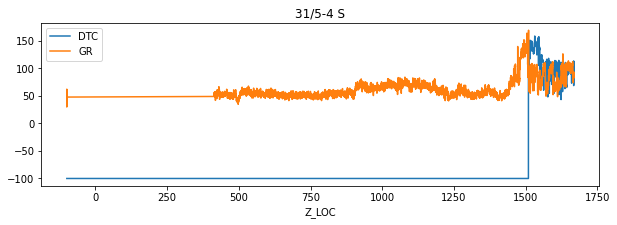

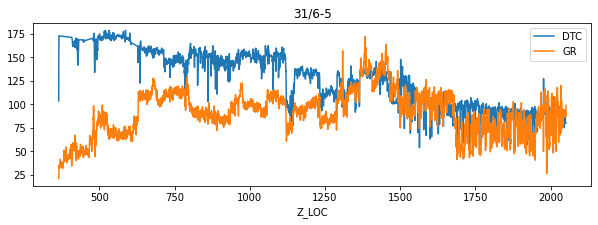

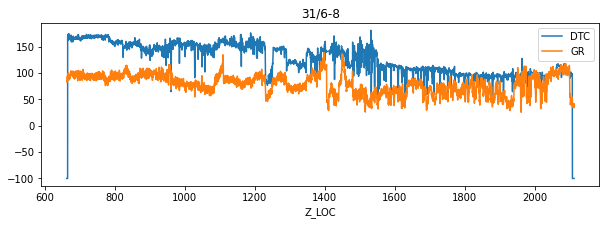

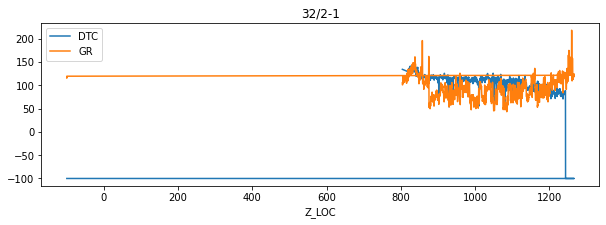

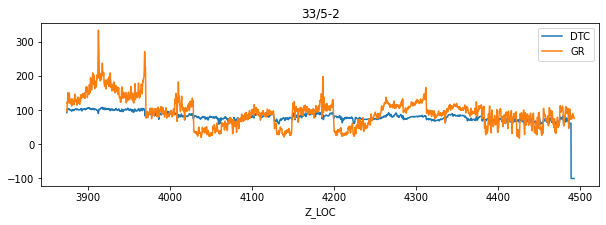

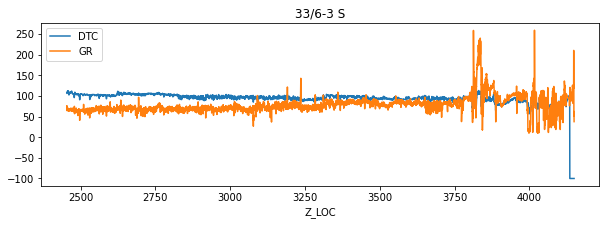

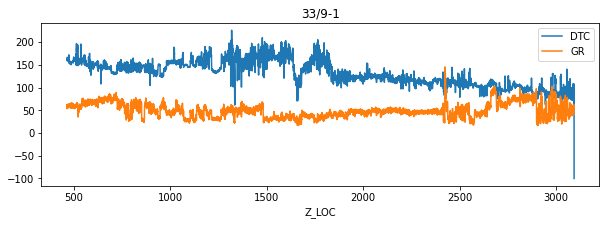

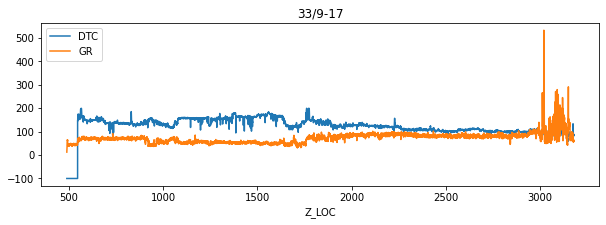

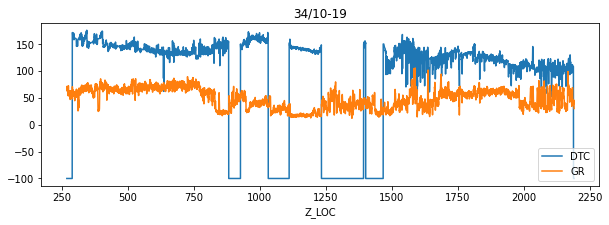

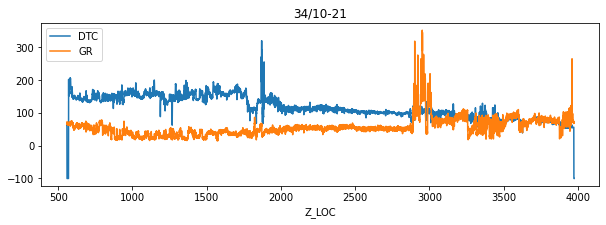

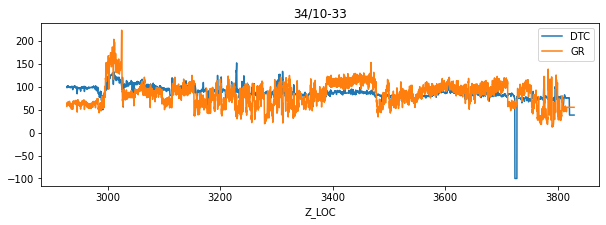

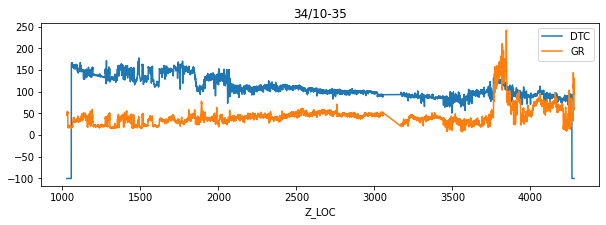

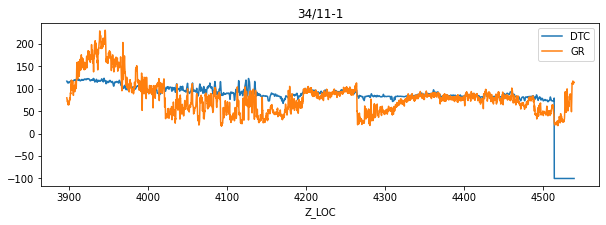

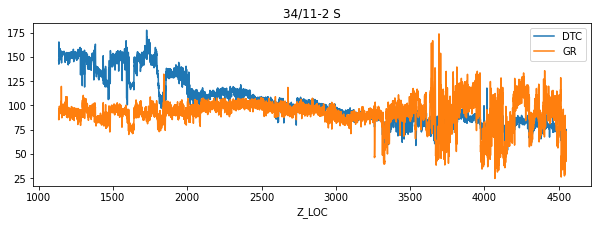

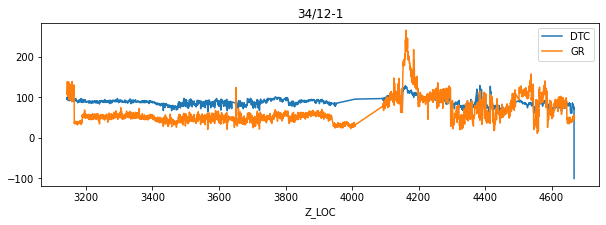

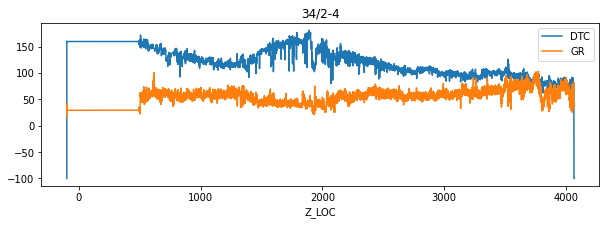

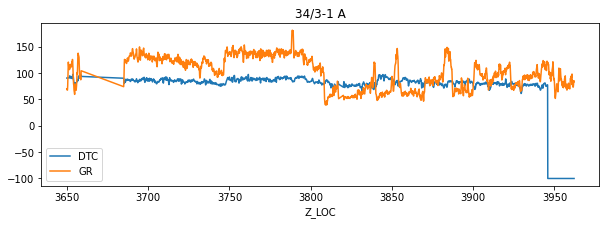

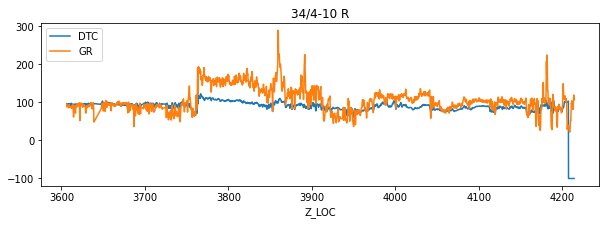

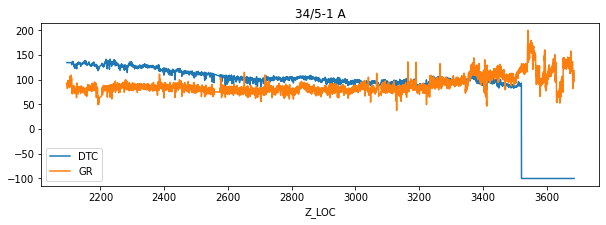

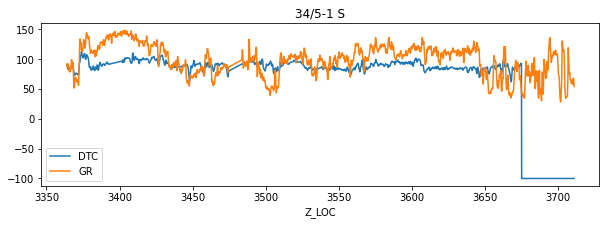

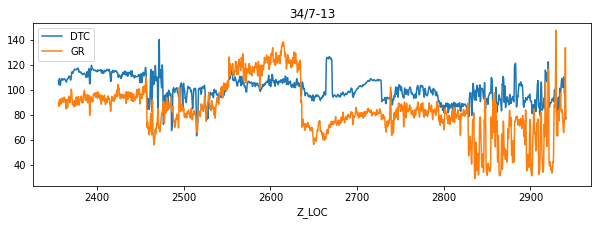

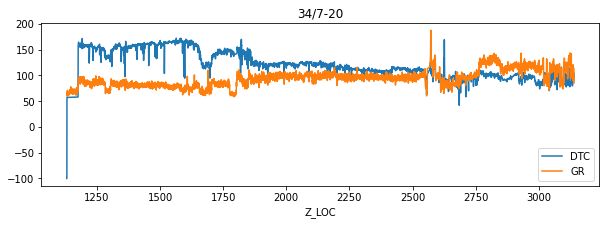

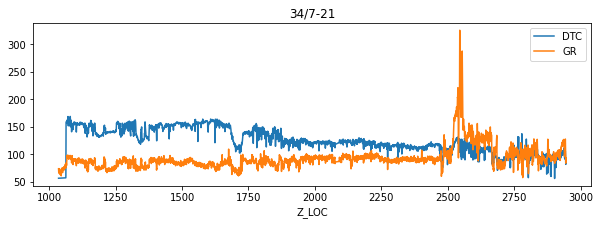

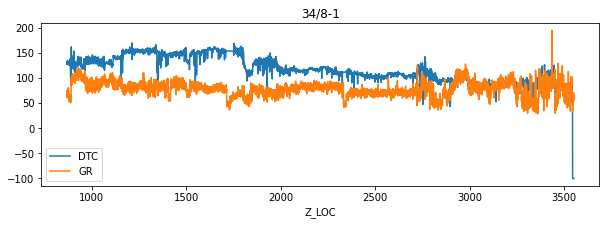

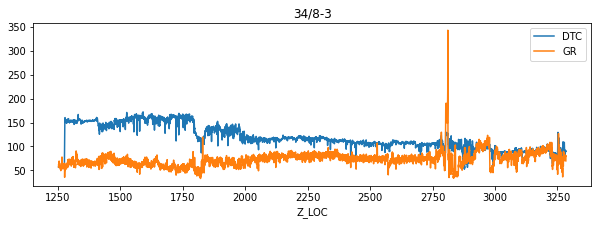

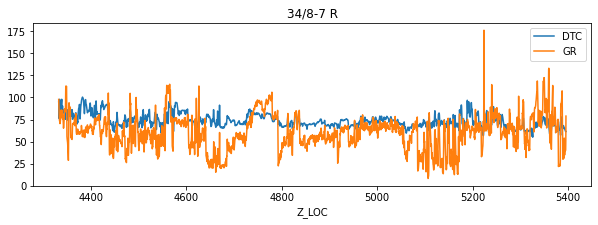

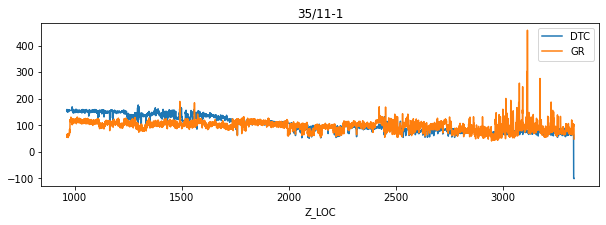

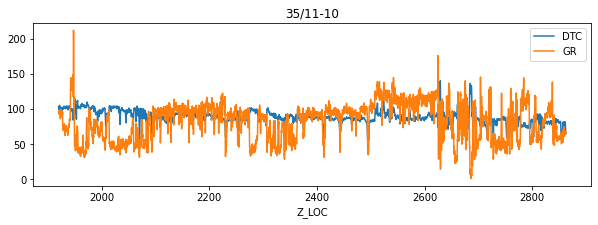

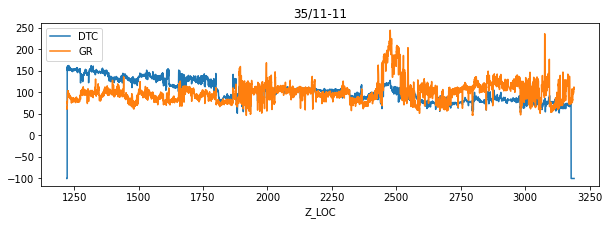

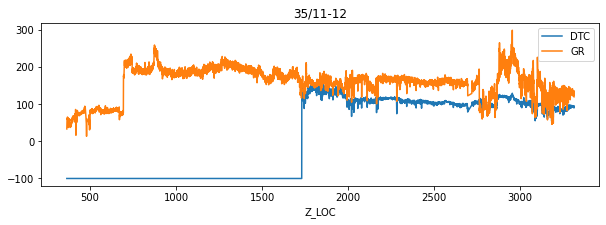

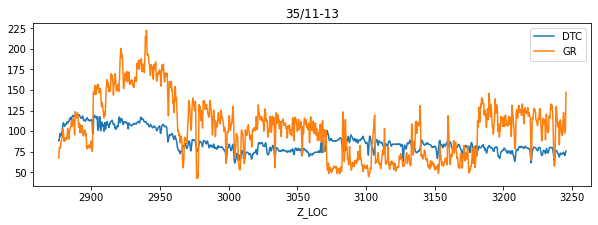

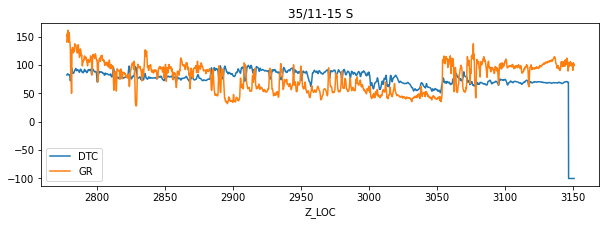

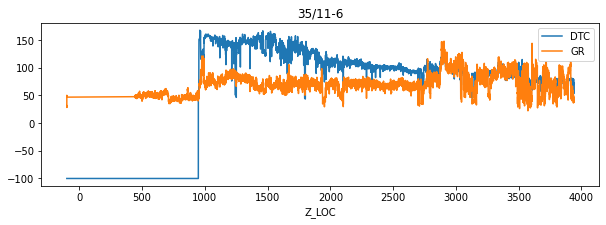

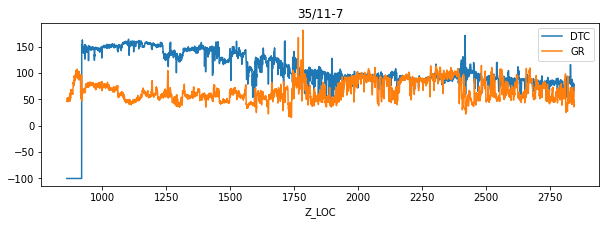

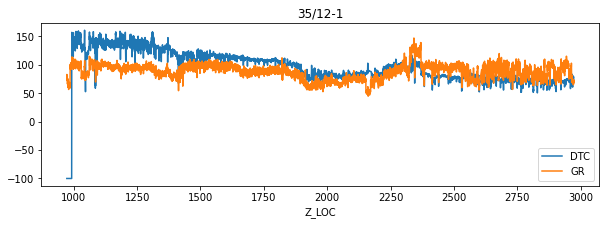

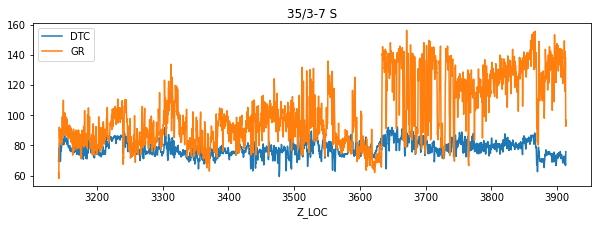

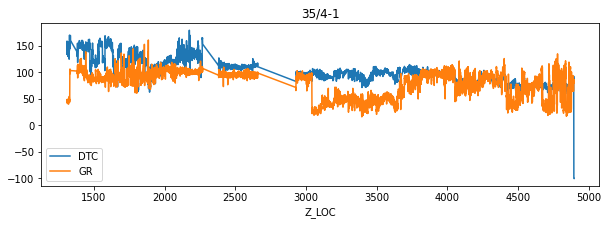

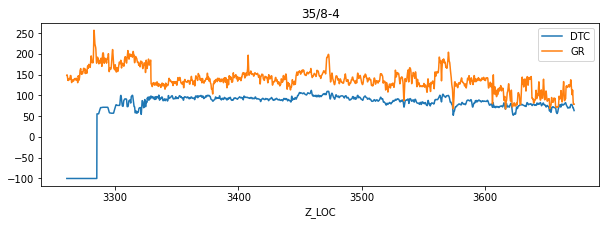

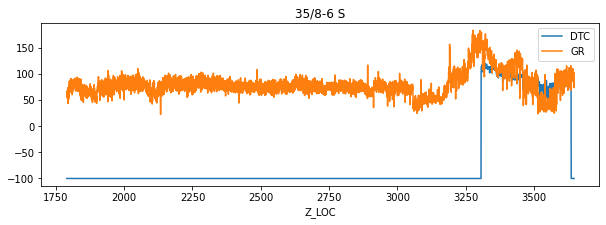

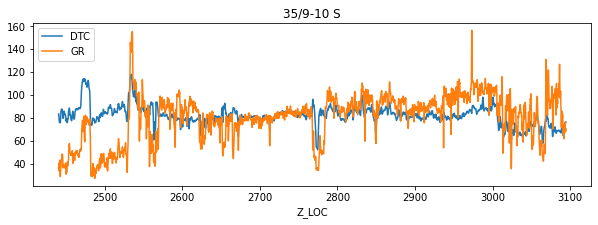

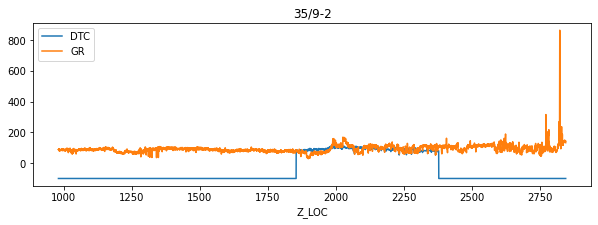

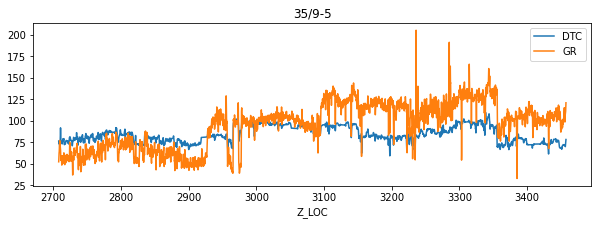

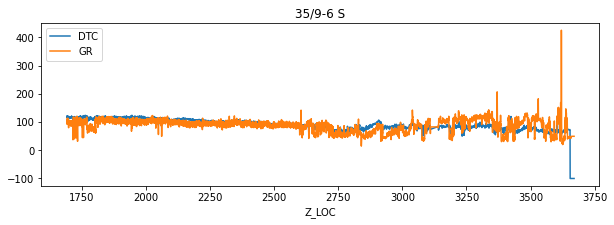

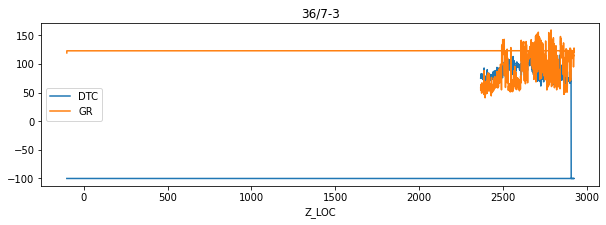

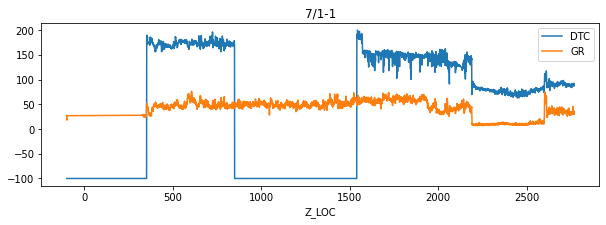

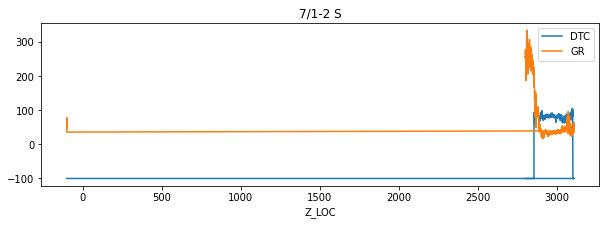

In [23]:
for well in dataset.wells_list:
    dataset.get_well(well, True).plot(x='Z_LOC', y=['DTC', 'GR'], kind='line', figsize=(10, 3), title=well)

<AxesSubplot:xlabel='Z_LOC'>

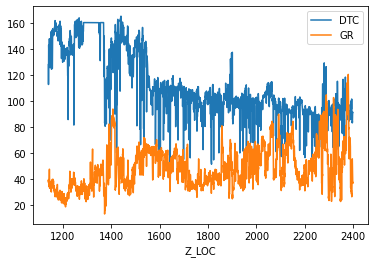

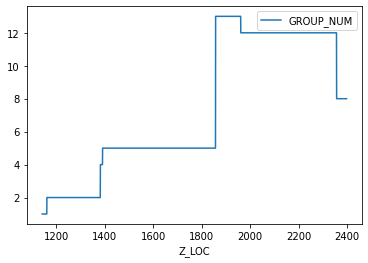

In [6]:
df_w1.plot(x = 'Z_LOC', y = ['DTC', 'GR'])
df_w1.plot(x = 'Z_LOC', y = 'GROUP_NUM')

In [8]:
df_w1.loc[:, ['GR', 'DTC']].values

array([[ 38.67681122, 127.92295074],
       [ 39.4918251 , 118.05770874],
       [ 38.51543045, 112.68775177],
       ...,
       [ 36.98509979,  91.30835724],
       [ 36.7869072 ,  91.29797363],
       [ 37.4898262 ,  91.28762054]])

In [12]:
'GT' in df_w1.columns

False

In [33]:
group_seq = df_w1.loc[:, 'GROUP_NUM'].values
z = df_w1.loc[:, 'Z_LOC'].values

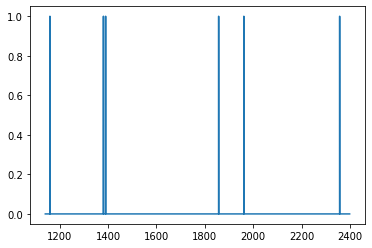

In [34]:
diff = np.zeros(group_seq.shape)
diff[1:] = group_seq[1:] - group_seq[:-1]
diff[diff != 0] = 1
plt.plot(z, diff)
plt.show()

In [35]:
def get_window(df : pd.DataFrame, 
               w_size : int = 10, 
               cols : List[str] = ['DTC', 'GR']) -> Tuple[np.ndarray, List[np.ndarray]]:
    template = []
    group_seq = df.loc[:, 'GROUP_NUM'].values
    diff = np.zeros(group_seq.shape)
    diff[1:] = group_seq[1:] - group_seq[:-1]
    idx = np.where(diff != 0)[0]
    cols = [i if col in cols else None for i, col in enumerate(df.columns) ]
    
    tmp_ = []
    for col in cols:
        if col is not None:
            tmp_ += [col]
            
    cols = tmp_
    
    for i in idx:
        w_list = np.zeros((w_size, len(cols)), dtype = np.float32)
        left_lim, right_lim = max(0, i-w_size//2), min(i+w_size//2, diff.shape[0]) 
        
        w_list = df.iloc[left_lim:right_lim, cols].values
        template += [w_list]
    
    return idx, template

In [36]:
idx, templates = get_window(df_w1, w_size=500)

In [37]:
target_template = templates[3]

In [38]:
def match(target_df, template, cols = [2, 3]):
    correlation_vals = [[] for i in cols]
    
    n = target_df.shape[0]
    
    template /= np.sum(template, axis=0)
    for i, col in enumerate(cols):
        feature_seq = target_df.iloc[:, col].values
        feature_seq /= np.sum(feature_seq)
        feature_seq = np.pad(feature_seq, template.shape[1]//2, mode='constant', constant_values = 0)
        
        for k in range(n):
            j = k + 1
            local_patch = feature_seq[j:j + template.shape[0]]
            correlation_vals[i] += [np.correlate(template[:, i], local_patch)[0]]
    
    return np.array(correlation_vals, dtype=np.float32)

In [39]:
target_df = dataset.get_well(matching_wells[2])
target_df.sample(10)

,WELL,Z_LOC,GR,DTC,GROUP,GROUP_NUM
569783,31/2-7,1274.922729,77.855522,151.356537,HORDALAND GP.,1
568525,31/2-7,1083.723877,85.749817,139.575256,HORDALAND GP.,1
568896,31/2-7,1140.112793,67.951492,156.143906,HORDALAND GP.,1
565094,31/2-7,562.221375,38.988586,138.034973,NORDLAND GP.,0
570082,31/2-7,1320.362793,82.802879,129.345886,ROGALAND GP.,2
567785,31/2-7,971.246216,79.621468,150.005280,HORDALAND GP.,1
567163,31/2-7,876.704163,78.113129,161.959061,HORDALAND GP.,1
571072,31/2-7,1470.830811,72.044365,141.075226,ROGALAND GP.,2
565531,31/2-7,628.644653,40.050407,134.943542,NORDLAND GP.,0
567652,31/2-7,951.030640,71.750221,161.036621,HORDALAND GP.,1


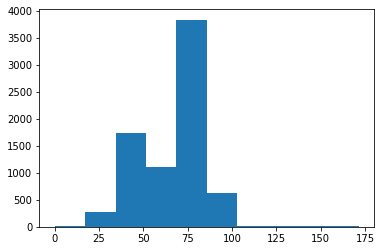

In [40]:
plt.hist(np.pad(target_df.iloc[:, 2].values, 5, mode='constant', constant_values = 0))
plt.show()

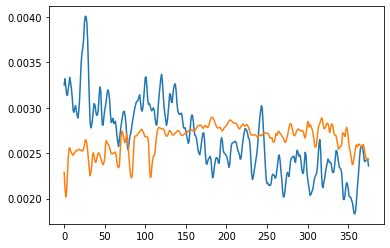

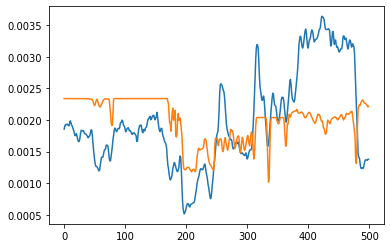

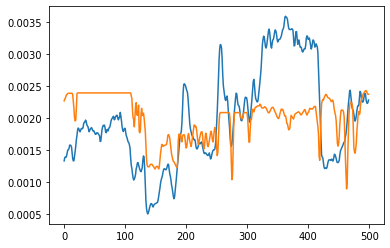

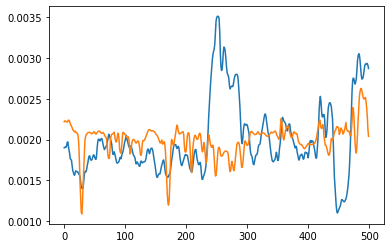

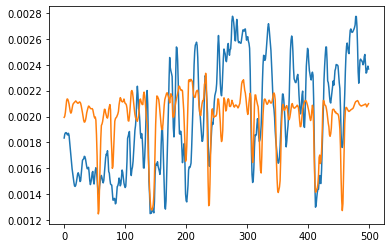

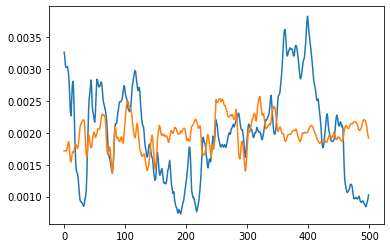

In [41]:
for template in templates:
    plt.plot(template/np.sum(template, axis = 0))
    plt.show()

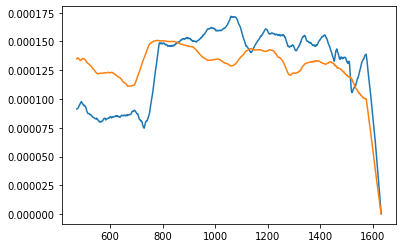

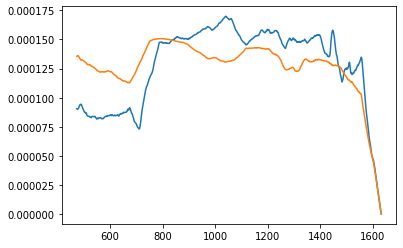

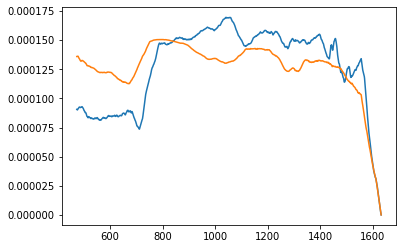

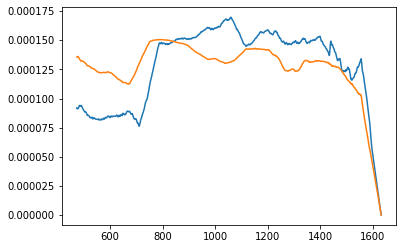

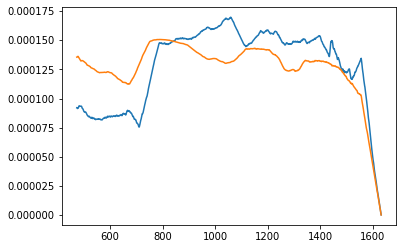

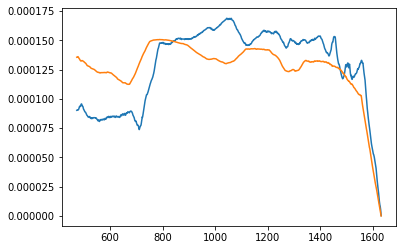

In [42]:
for template in templates:
    correlation_vals = match(target_df, template).T
#     correlation_vals = np.mean(correlation_vals, axis=1)
    plt.plot(target_df.Z_LOC.values, correlation_vals)
    plt.show()

In [43]:
group_seq = target_df.loc[:, 'GROUP_NUM'].values
z = target_df.loc[:, 'Z_LOC'].values

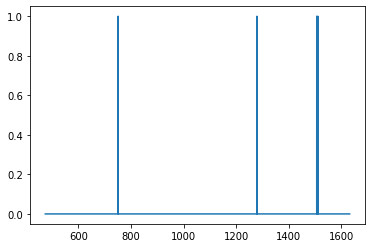

In [44]:
diff = np.zeros(group_seq.shape)
diff[1:] = group_seq[1:] - group_seq[:-1]
diff[diff != 0] = 1
plt.plot(z, diff)
plt.show()

In [45]:
target_df.isna().all()

WELL         False
Z_LOC        False
GR           False
DTC          False
GROUP        False
GROUP_NUM    False
dtype: bool